In [39]:
# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
# Libraries to perform statistical analysis
import scipy.stats as stats
import sklearn
# Library to split data
from sklearn.model_selection import train_test_split
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
import statsmodels.api as sm
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import pickle

In [40]:
# Loading the survey into out notebook
mhdata = pd.read_csv('../survey.csv')

In [41]:
# Dropping columns not needed/ not useful for EDA and modeling
mhdata.drop(columns=['Timestamp', 'Country', 'state', 'comments'], inplace = True)

In [42]:
# Renaming columns for uniformity and ease of understanding. We like uniformity!
mhdata.rename({'self_employed' : 'Self_Employed', 'family_history' : 'Family_History',
           'treatment' : 'Treatment', 'work_interfere' : 'Work_Interfere',
           'no_employees': 'Employee_Count_Company', 'remote_work': 'Remote_Work', 'tech_company': 'Tech_Company',
           'benefits': 'Benefits', 'care_options': 'Care_Options', 'wellness_program': 'Wellness_Program',
           'seek_help': 'Seek_Help', 'anonymity': 'Anonymity', 'leave': 'Medical_Leave',
           'mental_health_consequence': 'Mental_Health_Consequence',
           'phys_health_consequence': 'Physical_Health_Consequence', 'coworkers': 'Coworkers_Reach',
           'supervisor': 'Supervisor_Reach', 'mental_health_interview': 'Mental_Health_Interview',
           'phys_health_interview': 'Physical_Health_Interview', 'mental_vs_physical': 'Mental_VS_Physical',
           'obs_consequence': 'Observed_Consequence_Workplace'} , inplace = True , axis = 1)

In [43]:
# calculating the median age
median_age = mhdata['Age'].median()
print(median_age)

31.0


In [44]:
# since some of data are impossible to work with, we will replace impossible values with the median age
mhdata['Age'].replace([mhdata['Age'][mhdata['Age'] < 15]], median_age, inplace = True)
mhdata['Age'].replace([mhdata['Age'][mhdata['Age'] > 100]], median_age, inplace = True)

mhdata['Age'].unique()

array([37, 44, 32, 31, 33, 35, 39, 42, 23, 29, 36, 27, 46, 41, 34, 30, 40,
       38, 50, 24, 18, 28, 26, 22, 19, 25, 45, 21, 43, 56, 60, 54, 55, 48,
       20, 57, 58, 47, 62, 51, 65, 49, 53, 61, 72], dtype=int64)

In [45]:
# We will only limit our analysis to three categories
mhdata['Gender'].replace(['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make',], 'Male', inplace = True)

mhdata['Gender'].replace(['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

mhdata["Gender"].replace(['Female (trans)', 'queer/she/they', 'non-binary',
                     'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman',], 'Queer', inplace = True)

Data preprocessing

In [46]:
mhdata['Treatment'] = np.where(mhdata['Treatment'] == 'Yes', 1, 0)

In [47]:
# Now, we separate our dependent and independent variables.
X = mhdata.drop(["Treatment"], axis=1)
Y = mhdata["Treatment"]

# The independent variables will be transformed into dummy variables
X = pd.get_dummies(X, drop_first=True)

# adding constant. This is a requirement of Stats Model library. It creates a new column with float value 1
X = sm.add_constant(X)

In [48]:
# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1
)

In [49]:
# Initialize your models (assuming they are already defined)
svm_model = SVC()
lr_model = LogisticRegression()
boost = AdaBoostClassifier()
gb_model = GradientBoostingClassifier()
mlp_model = MLPClassifier()
dTree = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()

In [50]:
# Import necessary libraries
from sklearn.ensemble import StackingClassifier
# Initialize the base classifiers
base_classifiers = [('SVM',svm_model),('LogisticRegression',lr_model),('AdaBoostClassifier',boost),('GradientBoostingClassifier',gb_model),('MLPClassifier',mlp_model),('DecisionTreeClassifier',dTree),('KNN_Classifier',knn_model)]
# Create a meta-classifier
# Initialize the meta-classifier
meta_classifier = svm_model
stack = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)
stack.fit(X_train, y_train)


StackingClassifier(estimators=[('SVM', SVC()),
                               ('LogisticRegression', LogisticRegression()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('MLPClassifier', MLPClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('KNN_Classifier', KNeighborsClassifier())],
                   final_estimator=SVC())

In [51]:
from sklearn.calibration import CalibratedClassifierCV
# Initialize CalibratedClassifierCV
calibrated_stack = CalibratedClassifierCV(stack, method='sigmoid', cv='prefit')
# Fit CalibratedClassifierCV
calibrated_stack.fit(X_train, y_train)
# Make predictions
y_pred_proba = calibrated_stack.predict_proba(X_test)

In [52]:
new_respondent = pd.DataFrame([{
    'const': 1,
    'Age': 27,
    'Gender_Male': 0,
    'Gender_Queer': 0,
    'Self_Employed_Yes': 0,
    'Family_History_Yes': 1,
    'Work_Interfere_Often': 0,
    'Work_Interfere_Rarely': 0,
    'Work_Interfere_Sometimes': 1,
    'Employee_Count_Company_100-500': 0,
    'Employee_Count_Company_26-100': 1,
    'Employee_Count_Company_500-1000': 0,
    'Employee_Count_Company_6-25': 0,
    'Employee_Count_Company_More than 1000': 0,
    'Remote_Work_Yes': 1,
    'Tech_Company_Yes': 1,
    'Benefits_No': 0,
    'Benefits_Yes': 1,
    'Care_Options_Not sure': 0,
    'Care_Options_Yes': 1,
    'Wellness_Program_No': 1,
    'Wellness_Program_Yes': 0,
    'Seek_Help_No': 0,
    'Seek_Help_Yes': 1,
    'Anonymity_No': 0,
    'Anonymity_Yes': 1,
    'Medical_Leave_Somewhat difficult': 0,
    'Medical_Leave_Somewhat easy': 0,
    'Medical_Leave_Very difficult': 0,
    'Medical_Leave_Very easy': 1,
    'Mental_Health_Consequence_No': 0,
    'Mental_Health_Consequence_Yes': 0,
    'Physical_Health_Consequence_No': 0,
    'Physical_Health_Consequence_Yes': 0,
    'Coworkers_Reach_Some of them': 0,
    'Coworkers_Reach_Yes': 1,
    'Supervisor_Reach_Some of them': 0,
    'Supervisor_Reach_Yes': 0,
    'Mental_Health_Interview_No': 0,
    'Mental_Health_Interview_Yes': 0,
    'Physical_Health_Interview_No': 0,
    'Physical_Health_Interview_Yes': 0,
    'Mental_VS_Physical_No': 0,
    'Mental_VS_Physical_Yes': 1,
    'Observed_Consequence_Workplace_Yes': 0,


}],columns=[
    'const',
    'Age',
    'Gender_Male',
    'Gender_Queer',
    'Self_Employed_Yes',
    'Family_History_Yes',
    'Work_Interfere_Often',
    'Work_Interfere_Rarely',
    'Work_Interfere_Sometimes',
    'Employee_Count_Company_100-500',
    'Employee_Count_Company_26-100',
    'Employee_Count_Company_500-1000',
    'Employee_Count_Company_6-25',
    'Employee_Count_Company_More than 1000',
    'Remote_Work_Yes',
    'Tech_Company_Yes',
    'Benefits_No',
    'Benefits_Yes',
    'Care_Options_Not sure',
    'Care_Options_Yes',
    'Wellness_Program_No',
    'Wellness_Program_Yes',
    'Seek_Help_No',
    'Seek_Help_Yes',
    'Anonymity_No',
    'Anonymity_Yes',
    'Medical_Leave_Somewhat difficult',
    'Medical_Leave_Somewhat easy',
    'Medical_Leave_Very difficult',
    'Medical_Leave_Very easy',
    'Mental_Health_Consequence_No',
    'Mental_Health_Consequence_Yes',
    'Physical_Health_Consequence_No',
    'Physical_Health_Consequence_Yes',
    'Coworkers_Reach_Some of them',
    'Coworkers_Reach_Yes',
    'Supervisor_Reach_Some of them',
    'Supervisor_Reach_Yes',
    'Mental_Health_Interview_No',
    'Mental_Health_Interview_Yes',
    'Physical_Health_Interview_No',
    'Physical_Health_Interview_Yes',
    'Mental_VS_Physical_No',
    'Mental_VS_Physical_Yes',
    'Observed_Consequence_Workplace_Yes',],)
new_respondent

,const,Age,Gender_Male,Gender_Queer,Self_Employed_Yes,Family_History_Yes,Work_Interfere_Often,Work_Interfere_Rarely,Work_Interfere_Sometimes,Employee_Count_Company_100-500,Employee_Count_Company_26-100,Employee_Count_Company_500-1000,Employee_Count_Company_6-25,Employee_Count_Company_More than 1000,Remote_Work_Yes,Tech_Company_Yes,Benefits_No,Benefits_Yes,Care_Options_Not sure,Care_Options_Yes,Wellness_Program_No,Wellness_Program_Yes,Seek_Help_No,Seek_Help_Yes,Anonymity_No,Anonymity_Yes,Medical_Leave_Somewhat difficult,Medical_Leave_Somewhat easy,Medical_Leave_Very difficult,Medical_Leave_Very easy,Mental_Health_Consequence_No,Mental_Health_Consequence_Yes,Physical_Health_Consequence_No,Physical_Health_Consequence_Yes,Coworkers_Reach_Some of them,Coworkers_Reach_Yes,Supervisor_Reach_Some of them,Supervisor_Reach_Yes,Mental_Health_Interview_No,Mental_Health_Interview_Yes,Physical_Health_Interview_No,Physical_Health_Interview_Yes,Mental_VS_Physical_No,Mental_VS_Physical_Yes,Observed_Consequence_Workplace_Yes
0,1,27,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [53]:
predictionlg = calibrated_stack.predict(new_respondent)
print('Prediction:', predictionlg)

Prediction: [1]


In [54]:
pickle.dump(calibrated_stack,open('model.pkl','wb'))
model=pickle.load(open('model.pkl','rb'))

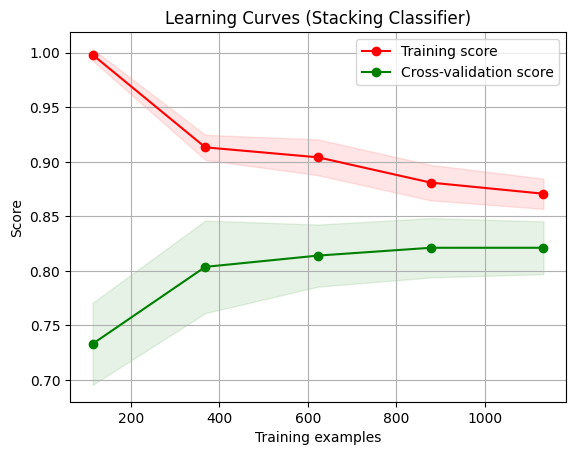

In [60]:
# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Plot learning curves
plot_learning_curve(stack, "Learning Curves (Stacking Classifier)", X, Y, cv=10, n_jobs=-1)
plt.show()